# Alphanumeric recognition

In [1]:
import pickle
import tensorflow as tf
from tensorflow.python import  keras
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPool2D
from tensorflow.python.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import h5py
import random
import sys


from sklearn.model_selection import train_test_split

## Unpickling data

In [2]:
with open("../train.pkl","rb") as infile:
    (X, y) = pickle.load(infile)

In [3]:
X = X.reshape(30134,56,56,1)
y = y.ravel()

## Look at the data

Data contains 56x56 written letters and number. Below random sample from data is shown.

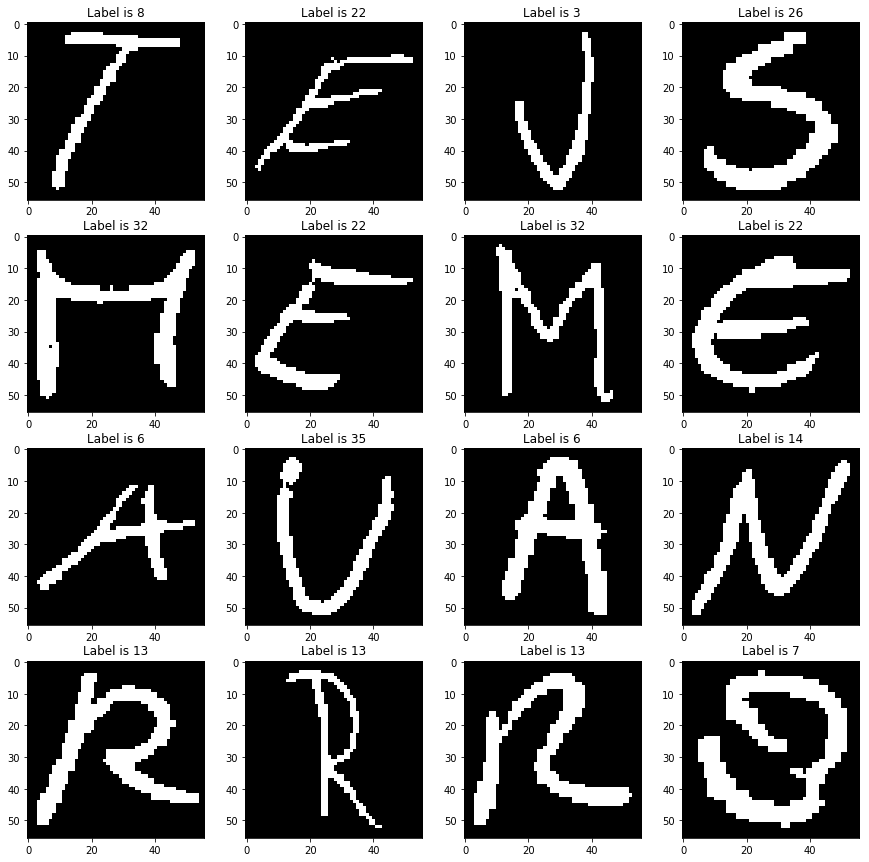

In [4]:
X_train,  X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

random_indices = np.random.randint(0, X_train.shape[0], size=16)

fig = plt.figure(figsize=(15,15))
for i, ridx in enumerate(random_indices):
    fig.add_subplot(4,4,i+1)
    plt.title('Label is {label}'.format(label=y_train[ridx]))
    plt.imshow(X_train[ridx,:,:,0], cmap='gray')
plt.show()

In [5]:
num_classes =36 

X_train = X_train.astype('uint8')
X_test = X_test.astype('uint8')

X_train_fc = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_fc = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

y_train_1h = keras.utils.to_categorical(y_train, num_classes)
y_test_1h = keras.utils.to_categorical(y_test, num_classes)

## Fully connected model

5x Fully Connected Layer

ReLU activation is used (except from output layer where softmax is used).

In [6]:
epochs = 30

model_fc = Sequential()
model_fc.add(Dropout(0.2, input_shape=(3136,)))
model_fc.add(Dense(700, activation='relu'))
model_fc.add(Dropout(0.5))
model_fc.add(Dense(700, activation='relu'))
model_fc.add(Dropout(0.5))
model_fc.add(Dense(500, activation='relu'))
model_fc.add(Dropout(0.5))
model_fc.add(Dense(500, activation='relu'))
model_fc.add(Dense(num_classes, activation='softmax'))


model_fc.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [7]:
print(model_fc.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 700)               2195900   
_________________________________________________________________
dropout_2 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 700)               490700    
_________________________________________________________________
dropout_3 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               350500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
__________

In [10]:
EStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model_fc.fit(X_train_fc, y_train_1h,
                    batch_size=128,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test_fc, y_test_1h),
                    callbacks=[EStop])
score_fc = model_fc.evaluate(X_test_fc, y_test_1h, verbose=0)

print('Test loss: {:.6f}'.format(score_fc[0]))
print('Test accuracy: {:.2f} %'.format(score_fc[1]*100))


Train on 24107 samples, validate on 6027 samples
Epoch 1/30
24107/24107 [==============================] - 13s 546us/step - loss: 0.5486 - acc: 0.8342 - val_loss: 0.4278 - val_acc: 0.8578
Epoch 2/30
24107/24107 [==============================] - 11s 451us/step - loss: 0.4887 - acc: 0.8535 - val_loss: 0.4008 - val_acc: 0.8752
Epoch 3/30
24107/24107 [==============================] - 11s 454us/step - loss: 0.4592 - acc: 0.8632 - val_loss: 0.4028 - val_acc: 0.8580
Epoch 4/30
24107/24107 [==============================] - 12s 481us/step - loss: 0.4363 - acc: 0.8719 - val_loss: 0.3983 - val_acc: 0.8737
Epoch 5/30
24107/24107 [==============================] - 11s 468us/step - loss: 0.4206 - acc: 0.8787 - val_loss: 0.3705 - val_acc: 0.8761
Epoch 6/30
24107/24107 [==============================] - 12s 510us/step - loss: 0.4126 - acc: 0.8834 - val_loss: 0.3580 - val_acc: 0.8917
Epoch 7/30
24107/24107 [==============================] - 13s 519us/step - loss: 0.3828 - acc: 0.8890 - val_loss: 0.3

## Convolution model

Model contains: 1xConvolution Layer, 3x(Convolution +Max Pooling), 2x Fully Connected.

ReLU activation is used (except from output layer where softmax is used).

In [11]:
epochs = 30

model_cnn = Sequential()
model_cnn.add(Dropout(0.2, input_shape=(56,56,1,)))
model_cnn.add(Conv2D(filters=16,kernel_size=(3,3),data_format="channels_last",input_shape=(56,56, 1,)))
model_cnn.add(Activation("relu"))
model_cnn.add(Conv2D(filters=32,kernel_size=(3,3),data_format="channels_last"))
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPool2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Conv2D(filters=64,kernel_size=(3,3),data_format="channels_last"))
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPool2D(pool_size=(2,2),data_format="channels_last"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Conv2D(filters=128,kernel_size=(3,3),data_format="channels_last"))
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPool2D(pool_size=(3,3),data_format="channels_last"))
model_cnn.add(Flatten())
model_cnn.add(Dense(500, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax'))


model_cnn.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [12]:
print(model_cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_5 (Dropout)          (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 52, 52, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 26, 26, 32)        0         
__________

In [14]:
model_cnn.fit(X_train, y_train_1h,
                    batch_size=128,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test_1h),
                callbacks=[EStop])
score_cnn = model_cnn.evaluate(X_test, y_test_1h, verbose=0)

print('Test loss: {:.6f}'.format(score_cnn[0]))
print('Test accuracy: {:.2f} %'.format(score_cnn[1]*100))

Train on 24107 samples, validate on 6027 samples
Epoch 1/30
24107/24107 [==============================] - 141s 6ms/step - loss: 1.1392 - acc: 0.6809 - val_loss: 0.6200 - val_acc: 0.8485
Epoch 2/30
24107/24107 [==============================] - 142s 6ms/step - loss: 0.4830 - acc: 0.8479 - val_loss: 0.4406 - val_acc: 0.8966
Epoch 3/30
24107/24107 [==============================] - 140s 6ms/step - loss: 0.3703 - acc: 0.8841 - val_loss: 0.5183 - val_acc: 0.9069
Epoch 4/30
24107/24107 [==============================] - 140s 6ms/step - loss: 0.3139 - acc: 0.8992 - val_loss: 0.3717 - val_acc: 0.9209
Epoch 5/30
24107/24107 [==============================] - 145s 6ms/step - loss: 0.2849 - acc: 0.9086 - val_loss: 0.2850 - val_acc: 0.9204
Epoch 6/30
24107/24107 [==============================] - 145s 6ms/step - loss: 0.2558 - acc: 0.9175 - val_loss: 0.2669 - val_acc: 0.9215
Epoch 7/30
24107/24107 [==============================] - 150s 6ms/step - loss: 0.2376 - acc: 0.9213 - val_loss: 0.2824 - v

## Choosing a model

Convolutional model offers 41.7 % error reduction on development set. It also has fewer parameters.

In [15]:
print('Error reduction: {:.2f} %'.format((score_cnn[1]-score_fc[1])/(1-score_fc[1])*100))

model_cnn.save("prediction_model.h5")

Error reduction: 41.67 %


## Short summary

Two simple neural networks architectures were proposed for the problem:
    
    a) Fully connected - data is treated as vector
    b) Convolutional - data is treated as images with height and width
    
For both architectures I have used dropout (0.2 in input, 0.5 in hidden layers) to reguralize data during training and early stoping to find optimal time to stop the training. During training validation loass was tracked. Those measures prevents overfiting.

I have used RMSprop as gradient optimization schedule. Activation in most layers is ReLU.

### Differences  in architectures

In convolutional architecture I use 2D Convolution as input layer 3 sets of 2D Convolution -> ReLU -> Max Pooling layers. Convolution layers allows to better "understand" spatial data. It achieves 41.7 % error reduction on validation set. Moreover convolutional architecture has around 5 times less parameters.

### Technologies

Keras model with tensorflow backend was used for the problem.